In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys
sys.path.append(os.path.abspath('.'))
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../run'))

import cv2
import itertools
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
from tqdm.notebook import tqdm
from scipy import ndimage
import skimage
import skimage.filters

from torchvision.transforms import functional as F

from IPython.display import display, Markdown

from simple_relational_reasoning.embeddings.containment_support_dataset import ContainmentSupportDataset

from simple_relational_reasoning.embeddings.stimuli import build_differet_shapes_stimulus_generator, build_split_text_stimulus_generator, build_random_color_stimulus_generator,\
    find_non_empty_indices, EMPTY_TENSOR_PIXEL, UNNORMALIZE
from simple_relational_reasoning.embeddings.triplets import QuinnTripletGenerator,\
    NoReferenceEquidistantTripletGenerator, NoReferenceDiagonalTripletGenerator,\
    SameHalfTripletGenerator, SameQuadrantTripletGenerator, TSNEStimuliSetGenerator, ABOVE_BELOW_RELATION, BETWEEN_RELATION

In [3]:

FIGURE_TEMPLATE = r'''\begin{{figure}}[!htb]
% \vspace{{-0.225in}}
\centering
\includegraphics[width=\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
% \vspace{{-0.2in}}
\end{{figure}}
'''
WRAPFIGURE_TEMPLATE = r'''\begin{{wrapfigure}}{{r}}{{0.5\linewidth}}
\vspace{{-.3in}}
\begin{{spacing}}{{1.0}}
\centering
\includegraphics[width=0.95\linewidth]{{figures/{save_path}}}
\caption{{ {{\bf FIGURE TITLE.}} FIGURE DESCRIPTION.}}
\label{{fig:{label_name}}}
\end{{spacing}}
% \vspace{{-.25in}}
\end{{wrapfigure}}'''

SAVE_PATH_PREFIX = 'figures'


def save_plot(save_path, bbox_inches='tight', should_print=False, should_prefix=True):
    if save_path is not None:
        save_path = os.path.abspath(save_path)
        save_path_no_ext = os.path.splitext(save_path)[0]
        if should_print:
            print('Figure:\n')
            print(FIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('\nWrapfigure:\n')
            print(WRAPFIGURE_TEMPLATE.format(save_path=save_path, label_name=save_path_no_ext.replace('/', '-').replace('_', '-')))
            print('')
        
        if not save_path.startswith(SAVE_PATH_PREFIX) and should_prefix:
            save_path = os.path.join(SAVE_PATH_PREFIX, save_path)
        
        folder, filename = os.path.split(save_path)
        os.makedirs(folder, exist_ok=True)
        plt.savefig(save_path, bbox_inches=bbox_inches, facecolor=plt.gcf().get_facecolor(), edgecolor='none')

In [13]:
reference_positions = [(105, 100)]

def plot_generator_examples(generator, ref_pos=reference_positions):
    plt.figure(figsize=(generator.n_target_types * 2.5, 3))

    for i in range(generator.n_target_types):
        x = generator.generate((80, 100 + (i * 20)), ref_pos, target_index=i)
        ax = plt.subplot(1, generator.n_target_types, i +1)
        ax.imshow(x.permute(1, 2, 0).numpy())


    plt.show()

def plot_triplets(triplets, plot_midlines=False, plot_diagonals=False, add_titles=True, save_path=None, custom_titles=None):
    n = triplets.shape[0]
    k = triplets.shape[1]

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.imshow(triplets[row, col].permute(1, 2, 0).numpy())

            if plot_midlines:
                ax.axhline(y=triplets.shape[-2] // 2, color='black', linestyle='--', alpha=0.5)
                ax.axvline(x=triplets.shape[-1] // 2, color='black', linestyle='--', alpha=0.5)
            
            if plot_diagonals:
                ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=0.5)
                ax.plot([1, 0], [0, 1], transform=ax.transAxes, color='black', linestyle='--', alpha=0.5)

            if add_titles:
                if row == 0:
                    if custom_titles is not None:
                        title = custom_titles[col]
                    elif col == k - 1:
                        title = 'Different Relation'
                    elif col == k - 2:
                        title = 'Same Relation'
                    else:
                        title = f'Habituation #{col + 1}'
                    
                    ax.set_title(title)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path)

    plt.show()

def plot_cropped_centered_triplets(triplets, canvas_size=(3, 200, 200), edge_color=(1, 0, 0)):
    n = triplets.shape[0]
    k = triplets.shape[1]

    if not isinstance(edge_color, torch.Tensor):
        edge_color = torch.tensor(edge_color, dtype=torch.float32).view(3, 1)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            img = triplets[row, col]
            r1, r2, c1, c2 = find_non_empty_indices(img, EMPTY_TENSOR_PIXEL, color_axis=0)
            img = img[:, r1:r2, c1:c2]
            canvas = torch.ones(*canvas_size)
            h = r2 - r1
            w = c2 - c1
            h_start = torch.div(canvas_size[1] - h, 2, rounding_mode='floor')
            w_start = torch.div(canvas_size[2] - w, 2, rounding_mode='floor')
            canvas[:, h_start:h_start + h, w_start:w_start + w] = img
            canvas[:, h_start - 1, w_start:w_start + w] = edge_color
            canvas[:, h_start + h, w_start:w_start + w] = edge_color
            canvas[:, h_start:h_start + h, w_start - 1] = edge_color
            canvas[:, h_start:h_start + h, w_start + w] = edge_color
            ax.imshow(canvas.permute(1, 2, 0).numpy())

            ax.set_title(f'{h} x {w} = {h * w}')

    fig.tight_layout()

    plt.show()

FLIPS = (
    lambda x: x,
    F.hflip,
    F.vflip,
    lambda x: F.hflip(F.vflip(x))
)

FLIP_NAMES = ('None', 'Horizontal', 'Vertical', 'Both')


def plot_flipped_versions(base_images, base_image_names, save_path=None,
    flips=FLIPS, flip_names=FLIP_NAMES, text_kwargs=None):

    if text_kwargs is None:
        text_kwargs = {}
    
    k = len(base_images)
    n = len(flips)

    fig = plt.figure(figsize=(2 * k, 2 * n))
    fig.patch.set_facecolor('white')

    for row in range(n):
        for col in range(k):
            ax = plt.subplot(n, k, (k * row) + col + 1)
            ax.set_xticks([])
            ax.set_yticks([])

            ax.imshow(flips[row](base_images[col]).permute(1, 2, 0).numpy())

            if row == 0:
                ax.set_title(base_image_names[col], **text_kwargs)

            if col == 0:
                ax.set_ylabel(flip_names[row], **text_kwargs)

    fig.tight_layout()

    if save_path is not None:
        save_plot(save_path, should_prefix=False)

    plt.show()


In [5]:
dataset = ContainmentSupportDataset('/Users/guydavidson/projects/BlockWorld/outputs/containtment_all_objects')
dataset.dataset.shape

In [7]:
dataset.dataset.shape

torch.Size([1024, 4, 3, 224, 224])

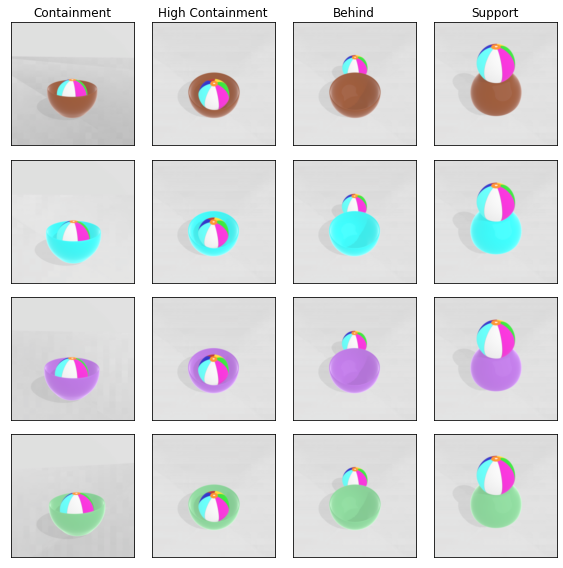

In [16]:
plot_triplets(UNNORMALIZE(dataset.dataset[0:32:8]), custom_titles=['Containment', 'High Containment', 'Behind', 'Support'])

In [1]:
import pandas as pd

In [2]:
!pwd

/Users/guydavidson/projects/simple-relational-reasoning/notebooks


In [4]:
df = pd.read_csv('../containment_support_outputs/baseline.csv')

In [5]:
df.head()

,Unnamed: 0,model,index,bowl_color,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos
0,0,mobilenet-saycam(S),0,blue,0.836229,0.794823,0.810463,0.889788,0.853038,0.938293
1,1,mobilenet-saycam(S),1,teal,0.834747,0.847929,0.805023,0.930568,0.827140,0.922434
2,2,mobilenet-saycam(S),2,purple,0.834538,0.810517,0.818926,0.932630,0.876944,0.929572
3,3,mobilenet-saycam(S),3,green,0.828959,0.826929,0.790142,0.918805,0.870504,0.954675
4,4,mobilenet-saycam(S),4,blue,0.840659,0.774696,0.759535,0.894770,0.845445,0.896895


In [9]:
df.head()

,Unnamed: 0,model,index,bowl_color,containment_high_containment_cos,containment_behind_cos,containment_support_cos,high_containment_behind_cos,high_containment_support_cos,behind_support_cos,correct
0,0,mobilenet-saycam(S),0,blue,0.836229,0.794823,0.810463,0.889788,0.853038,0.938293,True
1,1,mobilenet-saycam(S),1,teal,0.834747,0.847929,0.805023,0.930568,0.827140,0.922434,False
2,2,mobilenet-saycam(S),2,purple,0.834538,0.810517,0.818926,0.932630,0.876944,0.929572,True
3,3,mobilenet-saycam(S),3,green,0.828959,0.826929,0.790142,0.918805,0.870504,0.954675,True
4,4,mobilenet-saycam(S),4,blue,0.840659,0.774696,0.759535,0.894770,0.845445,0.896895,True
